In [4]:
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve, roc_curve
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Wrangle


In [5]:
# Pick target
target = 'USE2'

# Load construct dictionary
constructs=pd.read_csv('data/construct_measures.csv', index_col='variable')

# Display the target 
print(target,'-', constructs.loc[target].statement)

USE2 - I use Wikipedia as a platform to develop educational activities with students


In [6]:
def wrangle(df):
    df = df.copy()
    
    # Remap target to binary and drop neutral (3.0) values and null values
    df[target] = df[target].map({5:'Yes', 4: 'Yes', 2: 'No', 1: 'No'})
    df = df.dropna(subset=[target])

    return df.reset_index().drop(columns='index')

# Load and wrangle training data
df = wrangle(pd.read_csv('data/wiki4HE_train.csv',index_col=0))

In [7]:
df.sample(10)

,AGE,GENDER,DOMAIN,PHD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,INC1,INC2,INC3,INC4,EXP1,EXP2,EXP3,EXP4,EXP5
316,54,0,1.0,0,1.0,1,6.0,2.0,NaN,0.0,...,3.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,1.0,3.0
115,40,0,6.0,1,NaN,1,6.0,1.0,2.0,1.0,...,5.0,1.0,3.0,1.0,3.0,4.0,4.0,5.0,1.0,4.0
149,50,0,1.0,0,12.0,1,6.0,2.0,NaN,1.0,...,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,3.0
495,53,1,6.0,0,3.0,1,6.0,2.0,NaN,0.0,...,3.0,4.0,4.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0
88,46,1,5.0,1,17.0,1,1.0,NaN,NaN,0.0,...,3.0,4.0,2.0,1.0,3.0,3.0,4.0,4.0,1.0,1.0
572,37,0,2.0,0,12.0,2,NaN,NaN,7.0,NaN,...,5.0,2.0,2.0,1.0,1.0,4.0,5.0,5.0,4.0,5.0
588,33,0,1.0,0,2.0,2,NaN,NaN,7.0,0.0,...,1.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,3.0,1.0
236,34,0,6.0,0,3.0,1,6.0,2.0,NaN,1.0,...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,1.0
216,44,0,6.0,1,13.0,1,6.0,1.0,6.0,0.0,...,2.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,1.0
64,35,1,6.0,0,6.0,1,3.0,NaN,NaN,0.0,...,3.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,1.0,1.0


# Split Data

In [8]:
y = df[target]
X = df.drop(columns=df.loc[:,'USE1':'USE5'].columns)

Our model is going to use cross validation so we won't need to utilize a train-validate split.

# Baseline Metrics

In [9]:
print('Baseline Accuracy:', y.value_counts(normalize=True).max())

Baseline Accuracy: 0.8846787479406919


# Build Base Model

In [10]:
model = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier()
)

# Check Metrics

In [11]:
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross Validation Score LogisticRegression Model')
print(cv_scores)
print('Mean CV accuracy score:', cv_scores.mean())
print('STD CV accuracy score:', cv_scores.std())

Cross Validation Score LogisticRegression Model
[0.89344262 0.91803279 0.90909091 0.90909091 0.90082645]
Mean CV accuracy score: 0.9060967348597752
STD CV accuracy score: 0.008346280447187738


# Tune Model


In [17]:
model.named_steps['randomforestclassifier'].get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [18]:
params = {
    'randomforestclassifier__n_estimators': range(10,30),
    'randomforestclassifier__max_depth': range(5,100)
}

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid=params,
    scoring='roc_auc',
    cv=cross_validation
)

In [19]:
grid_search.fit(X,y)

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [29]:
grid_search.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=82, n_estimators=27))])

In [27]:
grid_search.best_score_

0.9126817237798546

In [48]:
y_pr = grid_search.predict_proba(X)[:,1]
roc_auc_score(y.map({'Yes':1,'No':0}), y_pr)

1.0

# Communicate Results

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

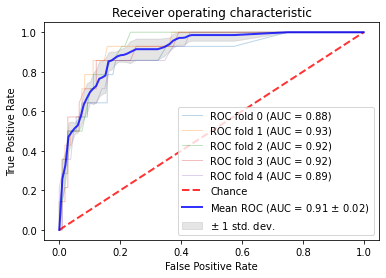

In [49]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
classifier = clone(model)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cross_validation.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

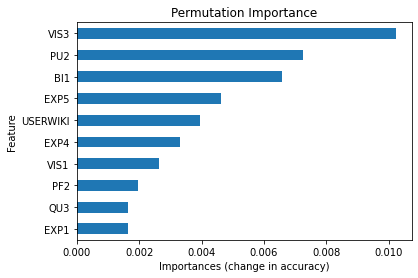

In [50]:
# Permutation importance
perm_imp = permutation_importance(estimator=classifier, X=X, y=y, random_state=42)

data = {
    'importances_mean': perm_imp['importances_mean'],
    'importances_std': perm_imp['importances_std']
}
pi_df = pd.DataFrame(data, index=X.columns).sort_values(by='importances_mean')

pi_df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importances (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation Importance');

In [51]:
for i in range(10):
    feature = pi_df.tail(10).index[i]
    print(feature, '-', constructs.loc[feature].statement)

EXP1 - I consult Wikipedia for issues related to my field of expertise
QU3 - Articles in Wikipedia are comprehensive
PF2 - I actively participate in social networks
VIS1 - Wikipedia improves visibility of students' work
EXP4 - I contribute to Wikipedia (editions, revisions, articles improvement...)
USERWIKI - Whether a registered Wikipedia user or not
EXP5 - I use wikis to work with my students
BI1 - In the future I will recommend the use of Wikipedia to my colleagues and students
PU2 - The use of Wikipedia improves students' learning
VIS3 - I cite Wikipedia in my academic papers
